# Model for combined covariate feature

## Environment setup

In [1]:
from pathlib import Path

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Time series feature engineering
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute

# Forecasting

import optuna
from mlforecast import MLForecast
from mlforecast.auto import (
    AutoMLForecast,
    AutoModel,
)
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
import xgboost as xgb

# Explaining
import shap
from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor

In [2]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [3]:
seed = sum(map(ord, "Covariate SHAP model - Uvira")) 
rng = np.random.default_rng(seed = seed)

## Folder Structure

In [4]:
raw_data_dir = Path("../../data/raw")
processed_data_dir = Path("../../data/processed")
img_dir = Path("../../images")
img_dir.mkdir(exist_ok=True)

## Functions

In [5]:
def xgbr_config(trial: optuna.Trial):
    return {
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),        
    }

def skgbr_config(trial: optuna.Trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "loss": trial.suggest_categorical("loss", ["squared_error", "absolute_error", "huber"]),
        # "loss": trial.suggest_categorical("loss", ["squared_error", "absolute_error"])
    }

def init_config_simple(trial: optuna.Trial):
    return {}

# Aggregation functions
def na_sum(x):
    if all(x.isna()):
        return np.nan
    else:
        return x.dropna().sum()

def na_log_sum(x):
    if all(x.isna()):
        return np.nan
    else:
        tot = x.dropna().sum()
        if tot > 0:
            return np.log(tot + 1)
        else:
            return -np.log(-tot + 1)

def na_mean(x):
    if all(x.isna()):
        return np.nan
    else:
        return x.dropna().mean()


def standardize(x):
    return (x - x.mean()) / x.std()


def normalize(x):
    return (x - x.min()) / (x.max() - x.min())


def mask_target(x):
    """
    this mask returns an array of 1s where the last entry is a 0.
    Used to mask the rolled time series to avoid using the target in the features.
    """
    result = np.ones(len(x))
    result[-1] = 0
    return result

## Import data

In [6]:
df = pd.read_csv(
    processed_data_dir / "uvira_full_data.csv",
    parse_dates=["date"]
)

In [7]:
df.head()

,date,reports,rdt_confirmed,vacc_1,vacc_1_prop,vacc_2,vacc_2_prop,rainfall_mm,ssm,subssm,esi,lake_level,num_conflicts,num_fatalities,num_disasters,num_disaster_affected,idps
0,2016-04-15,6,0,0.0,0.0,0.0,0.0,12.001953,24.716246,139.518494,NaN,771.6340,0.0,0.0,0.0,0.0,NaN
1,2016-04-16,24,0,0.0,0.0,0.0,0.0,11.792500,24.885131,139.597733,NaN,771.6155,0.0,0.0,0.0,0.0,NaN
2,2016-04-17,17,0,0.0,0.0,0.0,0.0,8.569291,25.054015,139.676971,NaN,771.5970,0.0,0.0,0.0,0.0,NaN
3,2016-04-18,17,0,0.0,0.0,0.0,0.0,3.274265,25.222900,139.756210,NaN,771.5785,0.0,0.0,0.0,0.0,NaN
4,2016-04-19,6,0,0.0,0.0,0.0,0.0,7.377607,25.281933,140.015559,NaN,771.5600,0.0,0.0,0.0,0.0,NaN


## Parameters

In [8]:
START_DATE = "2016-05-01"
END_DATE = df["date"].max().strftime("%Y-%m-%d")
TIME_BIN = 7
FORECAST_HORIZON = int(30 / TIME_BIN)

## Aggregate Data

In [9]:
df_weekly = (
    df
    .groupby(pd.Grouper(key = "date", freq = f"{TIME_BIN}D"), dropna=True)
    .agg({
        "reports": na_sum,
        "vacc_1": na_sum,
        "vacc_1_prop": na_sum,
        "vacc_2": na_sum,
        "vacc_2_prop": na_sum,
        "rdt_confirmed": na_sum,
        "rainfall_mm": na_mean,
        "esi": na_mean,
        "lake_level": na_mean,
        "num_conflicts": na_log_sum,
        "num_fatalities": na_log_sum,
        "num_disasters": na_log_sum,
        "num_disaster_affected": na_sum,
        "idps": na_sum,
    })
    .assign(
        unique_id = 1,
        num_disaster_affected = lambda x: x["num_disaster_affected"].rolling(window = 8, win_type = "exponential", center=False, min_periods = 0).mean(tau=1),
    )
    .loc[lambda x: (
        (x.index >= START_DATE)
        & (x.index < END_DATE)
    )]
    .reset_index()
    .rename(columns = {
        "date": "ds",
        "reports": "y"
    })
)

array([<Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>], dtype=object)

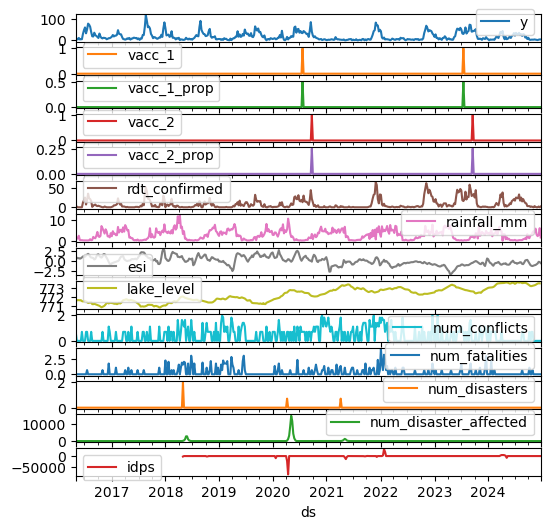

In [10]:
(
    df_weekly
    .drop(columns = ["unique_id"])
    .set_index("ds")
    .plot(subplots = True, figsize = (6, 6))
)

We consider only the people affected by disasters in the following considering that this is a proxy for water supply disruption (all disasters are floods). 

People affected by conflict we assume are captured by the idps data.

In [11]:
df_weekly_for_model = (
    df_weekly
    [[
        "unique_id",
        "ds",
        "y",
        "rainfall_mm",
        "esi",
        "lake_level",
        "num_fatalities",
    ]]
    .assign(
        rainfall_mm = lambda x: standardize(x["rainfall_mm"]),
        esi = lambda x: standardize(x["esi"]),
        lake_level = lambda x: standardize(x["lake_level"]),
        num_fatalities = lambda x: normalize(x["num_fatalities"]),
    )
    .dropna()
    .reset_index(drop = True)
)

array([<Axes: xlabel='ds'>, <Axes: xlabel='ds'>, <Axes: xlabel='ds'>,
       <Axes: xlabel='ds'>, <Axes: xlabel='ds'>], dtype=object)

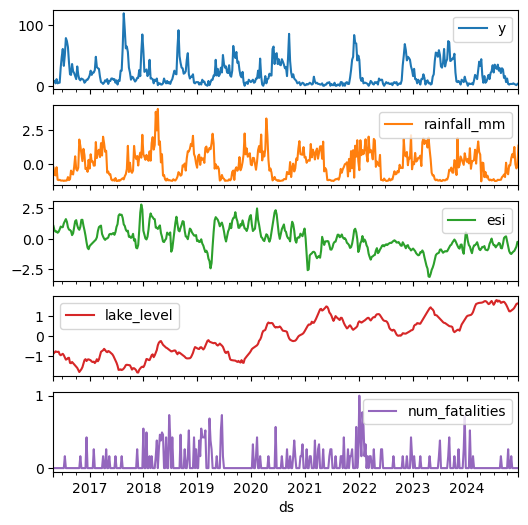

In [12]:
(
    df_weekly_for_model
    .drop(columns = ["unique_id"])
    .set_index("ds")
    .plot(subplots = True, figsize = (6, 6))
)

### Test date split

In [13]:
test_date_split = df_weekly["ds"].iloc[(
    df_weekly
    .loc[lambda x: x["ds"] > "2021-01-01"]
    .assign(
        thresh_cross = lambda x: x["y"] >= 15
    )
    ["thresh_cross"]
    .loc[lambda x: x == True]
    .index[0] + 1
)]

## Feature Engineering

### Create rolling datasets

Note that the rolling procedure includes the current timestamp so we need to drop the current value

In [14]:
lookback_period = 4
df_weekly_rolled = (
    roll_time_series(
        df_weekly_for_model.drop(columns=["y"]),
        column_id = "unique_id",
        column_sort = "ds",
        min_timeshift = lookback_period,
        max_timeshift = lookback_period
    )
    .drop(columns = ["unique_id"])
)

Rolling: 100%|██████████| 29/29 [00:02<00:00, 11.41it/s]


In [15]:
mask = (
    df_weekly_rolled
    .groupby("id")
    ["id"]
    .transform(mask_target)
    .astype(bool)
    .values
)

In [16]:
df_weekly_rolled_masked = (
    df_weekly_rolled
    .copy()
    [mask]
    .reset_index(drop = True)
)

### Build features

In [17]:
df_features = (
    extract_features(
        df_weekly_rolled_masked,
        column_id = "id",
        column_sort = "ds",
    )
    [lambda x: [c for c in x.columns if x[c].std() > 0]]
)

Feature Extraction: 100%|██████████| 30/30 [00:10<00:00,  2.77it/s]
/Users/paoich/miniforge3/envs/cholera-surveillance/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


### Feature Selection

#### All features

In [18]:
df_ts_model_features = (
    impute(df_features)
    .apply(lambda x: normalize(x), axis = 0)
    .reset_index()
    .drop(columns = ["level_0"])
    .rename(columns = {"level_1": "ds"})
    .dropna(axis = 1)
)

#### Select features from all data

In [19]:
df_features_filtered = select_features(
    impute(df_features),
    df_weekly_for_model["y"].values[lookback_period:],
)

In [20]:
df_ts_model_features_filtered = (
    df_features_filtered
    .apply(lambda x: normalize(x), axis = 0)
    .reset_index()
    .drop(columns = ["level_0"])
    .rename(columns = {"level_1": "ds"})
)

In [21]:
df_ts_model_features_filtered.shape

(447, 45)

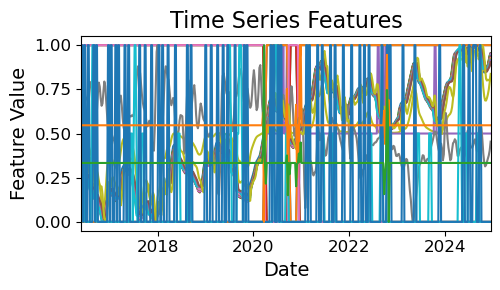

In [22]:
fig, ax = plt.subplots(figsize = (5, 3))
(
    df_ts_model_features_filtered
    .drop(columns = df_ts_model_features_filtered.columns[df_ts_model_features_filtered.drop(columns=["ds"]).max().argmax()+1])
    .set_index("ds")
    .plot(
        ax = ax,
        legend = False,
    )
)
ax.set(xticks=["2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
ax.set_xticklabels(["2018", "2020", "2022", "2024"], fontsize = 12) 
ax.tick_params(axis = "y", labelsize = 12)
ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("Feature Value", fontsize = 14)
ax.set_title("Time Series Features", fontsize = 16)
# plt.subplots_adjust(hspace = 0.3)
plt.tight_layout()
plt.minorticks_off()
fig.align_ylabels()
plt.savefig(img_dir / "engineered_features.png", dpi = 300, bbox_inches = "tight")

## Data for model

We use all the engineered features and let the model figure out which ones are most important.
We test this both on only the train data and on all data. Note that the train data possibly better replicates more a "standard" behavior given that there were fewer externalities during this period.

In [23]:
df_model = (
    df_weekly_for_model
    [[
        "unique_id", 
        "ds", 
        "y", 
        "rainfall_mm", 
        # "num_disaster_affected"
    ]]
    .assign(
        week = lambda x: 0.5 * (1 + np.sin(2 * np.pi * (x["ds"].dt.isocalendar().week + 30) / 52)),
        rain_sum_4w = lambda x: x["rainfall_mm"].rolling(window = 4, center=False, min_periods = 0).sum(),
        # disaster_sum_4w = lambda x: x["num_disaster_affected"].rolling(window = 4, center=False, min_periods = 0).sum(),
    )
    .drop(columns = [
        "rainfall_mm", 
        # "num_disaster_affected"
    ])
    .merge(
        df_ts_model_features,
        how = "left",
        on = "ds"
    )
    .dropna()
    .reset_index(drop = True)
)
    

In [24]:
OUTPUT_FILEDATE = pd.Timestamp("today").strftime("%Y%m%d")
(
    df_model
    .rename(
        columns = {
            "ds": "date",
            "y": "reports",
        }
    )
    .to_csv(processed_data_dir / f"uvira_model_data_{OUTPUT_FILEDATE}.csv", index=False)
)

In [25]:
df_model.shape

(447, 678)

## Train-validation-test split

In [26]:
df_train = df_model[df_model["ds"] < test_date_split].reset_index(drop=True)
df_test = df_model[df_model["ds"] >= test_date_split].reset_index(drop=True)

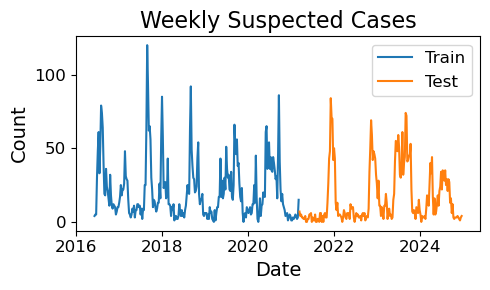

In [27]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(df_train["ds"], df_train["y"], label="Train")
ax.plot(df_test["ds"], df_test["y"], label="Test")
ax.legend(fontsize=12)
ax.set_title("Dataset Splits", fontsize=16)
ax.tick_params(labelsize = 12)
ax.set_title("Weekly Suspected Cases", fontsize = 16)
ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("Count", fontsize = 14)
ax.set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
ax.set_xticklabels(["2016", "2018", "2020", "2022", "2024"], fontsize = 12) 
plt.tight_layout()
plt.minorticks_off()
fig.align_ylabels()
plt.savefig(img_dir / "train_test_split.png", dpi = 300, bbox_inches = "tight")

## Simple Correlation Analysis

In [28]:
corr_factors = (
    df_model
    .drop(columns = ["unique_id", "ds"])
    .corr()
    ["y"]
    .T
    .to_frame(name = "corr")
    .loc[lambda x: x.index != "y"]
    .loc[lambda x: x["corr"] >= 0.01]
    .sort_values(by = "corr", ascending = False, key = np.abs)
)

#### Extract features with low correlation

In [29]:
list_of_relevant_features_simple = [corr_factors.index.tolist()[0]]
for f in corr_factors.index.tolist()[1:]:
    corrs = df_model[list_of_relevant_features_simple + [f]].corr()[f].abs()
    if corrs[:-1].max() < 0.3:
        list_of_relevant_features_simple.append(f)    

In [30]:
len(list_of_relevant_features_simple)

56

#### Final Dataset

In [31]:
df_reports_cov_corr_simple = (
    df_model
    [["ds", "y"] + list_of_relevant_features_simple]
    .assign(
        **{
            f"{feat}_corr": df_model[feat] * corr_factors.loc[lambda x: x.index == feat, "corr"].values[0]
            for feat in list_of_relevant_features_simple
        }
    )
    .assign(
        cov = lambda x: normalize(
            x
            [[c for c in x.columns if c.endswith("_corr")]]
            .sum(axis = 1)
        )
    )
    .merge(
        df_weekly[["ds", "idps", "num_disaster_affected"]],
        on = "ds",
        how = "left"
    )
    .rename(
        columns = {
            "ds": "date",
            "y": "reports"
        }
    )
    [["date", "reports", "idps", "num_disaster_affected", "cov"]]
)
    

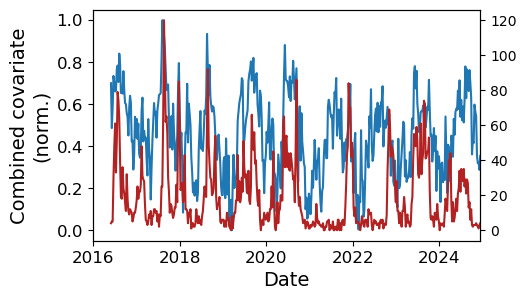

In [32]:
fig, ax = plt.subplots(figsize=(5, 3))
(
    df_reports_cov_corr_simple
    .set_index("date")
    .plot(
        y = "cov",
        ax = ax, 
        legend = False
    )
)
ax2 = ax.twinx()
(
    df_reports_cov_corr_simple
    .set_index("date")
    .plot(
        y = "reports",
        ax = ax2, 
        legend = False,
        color = "firebrick"
    )
)
ax.set_ylabel("Combined covariate\n(norm.)", fontsize = 14)
ax.set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
ax.set_xticklabels(["2016", "2018", "2020", "2022", "2024"], fontsize = 12) 
ax.set_xlabel("Date", fontsize = 14)
ax.tick_params(axis = "y", labelsize = 12)
plt.minorticks_off()
plt.savefig(img_dir / "combined_covariates.png", dpi = 300, bbox_inches = "tight")

## Model on Train Data

### Models

In [33]:
auto_xgbr_train = AutoModel(
    model=xgb.XGBRegressor(),
    config=xgbr_config,
)
auto_skgbr_train = AutoModel(
    model=GradientBoostingRegressor(),
    # model=HistGradientBoostingRegressor(),
    config=skgbr_config,
)

### Hyperparameter tuning

In [34]:
fcst_auto_train = AutoMLForecast(
    models = {
        "GradientBoostingRegressor": auto_skgbr_train,
        "XGBRegressor": auto_xgbr_train,
    },
    freq=f"{TIME_BIN}D",
    init_config = init_config_simple,
    fit_config=lambda trial: {'static_features': []}
)

In [35]:
fcst_auto_train.fit(
    df_train,
    n_windows=5,
    h=FORECAST_HORIZON,
    num_samples=3,
    fitted = True,
)

AutoMLForecast(models={'GradientBoostingRegressor': AutoModel(model=GradientBoostingRegressor), 'XGBRegressor': AutoModel(model=XGBRegressor)})

### Predictions on Train Set

In [36]:
df_forecast_auto_train = (
    fcst_auto_train
    .forecast_fitted_values()
    .drop(columns = ["unique_id"])
)

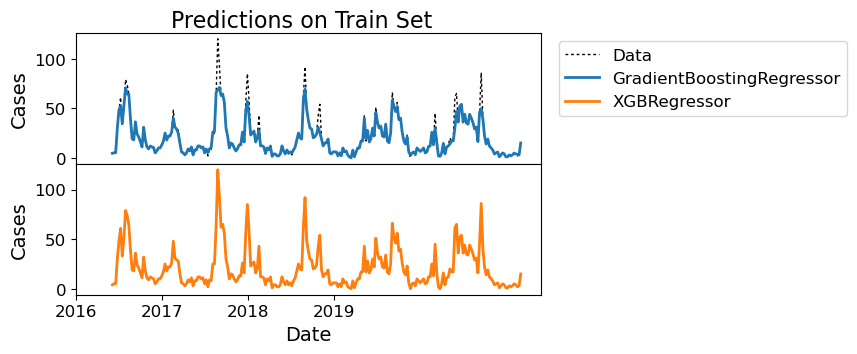

In [37]:
num_models_auto = len(fcst_auto_train.models)
fig, axes = plt.subplots(num_models_auto, 1, figsize=(6, 1.7 * num_models_auto), sharex=True)
for i in range(num_models_auto):
    axes[i].plot(
        df_train["ds"],
        df_train["y"],
        color = "black",
        linewidth = 1,
        dashes = [2, 2],
        label = "Data"
    )
    axes[i].plot(
        df_forecast_auto_train["ds"],
        df_forecast_auto_train.iloc[:, 2 + i],
        color = f"C{i}",
        linewidth = 2,
        label = df_forecast_auto_train.columns[2 + i]
    )
    axes[i].tick_params(labelsize = 12)
    axes[i].set_ylabel("Cases", fontsize = 14)
    axes[i].set(xticks=["2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"])
    axes[i].set_xticklabels(["2016", "2017", "2018", "2019"]);


lines_labels = [ax.get_legend_handles_labels() for ax in axes]
h, l = [sum(lol, []) for lol in zip(*lines_labels)]
h = [h[0]] + h[1::2]
l = [l[0]] + l[1::2]
axes[0].legend(
    h, 
    l, 
    bbox_to_anchor=(1.02, 1),
    fontsize = 12
)
axes[-1].set_xlabel("Date", fontsize = 14)
plt.suptitle("Predictions on Train Set", fontsize = 16, y = 0.95)
plt.subplots_adjust(hspace = 0)

### Predictions on Test Set

We just look at how well the model does at long-term predictions.

In [38]:
pred_window = 160
df_forecast_auto_train = (
    fcst_auto_train.predict(
        h = pred_window,
        X_df = df_test.drop(columns = ["y"]).iloc[:pred_window],
    )
    .drop(columns = ["unique_id"])
    .set_index("ds")
    .clip(lower=0)   # We clip the prediction boundaries to zero
    .reset_index()
)

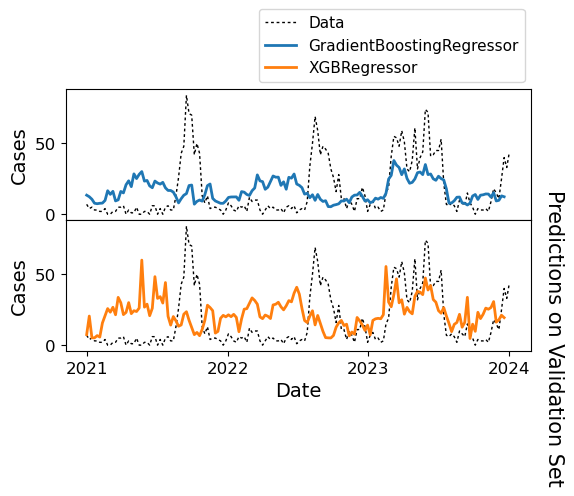

In [39]:
model_labels = ["GradientBoostingRegressor", "XGBRegressor"]
num_models_auto = len(fcst_auto_train.models)
dates_true = df_test["ds"].iloc[:pred_window + 2]
chol_true = df_test["y"].iloc[:pred_window + 2]
dates_range = (dates_true.max() - dates_true.min()).days
dates_ticks = pd.date_range(start=dates_true.min(), end=dates_true.max(), periods = 4)
fig, axes = plt.subplots(num_models_auto, 1, figsize=(6, 1.7 * num_models_auto), sharex=True)
for i in range(num_models_auto):
    axes[i].plot(
        dates_true,
        chol_true,
        color = "black",
        linewidth = 1,
        dashes = [2, 2],
        label = "Data"
    )
    axes[i].plot(
        df_forecast_auto_train["ds"],
        df_forecast_auto_train.iloc[:, 1 + i],
        color = f"C{i}",
        linewidth = 2,
        label = model_labels[i]
    )
    axes[i].tick_params(labelsize = 12)
    axes[i].set_ylabel("Cases", fontsize = 14)
    axes[i].set(xticks=dates_ticks)
    if (dates_range < 120):
        axes[i].set_xticklabels([d.strftime("%Y-%m-%d") for d in dates_ticks])
    elif (dates_range < 365):
        axes[i].set_xticklabels([d.strftime("%Y-%m") for d in dates_ticks])
    else:
        axes[i].set_xticklabels([d.strftime("%Y") for d in dates_ticks])


lines_labels = [ax.get_legend_handles_labels() for ax in axes]
h, l = [sum(lol, []) for lol in zip(*lines_labels)]
h = [h[0]] + h[1::2]
l = [l[0]] + l[1::2]
axes[0].legend(
    h, 
    l, 
    bbox_to_anchor=(0.4, 1),
    fontsize = 11
)
axes[-1].set_xlabel("Date", fontsize = 14)
plt.text(1.03, -2, "Predictions on Validation Set", fontsize = 15, rotation = 270, transform=axes[0].transAxes)
plt.subplots_adjust(hspace = 0)

### Refit best models

In [40]:
xgbr_final_train = xgb.XGBRegressor(**fcst_auto_train.results_["XGBRegressor"].best_params)
skgbr_final_train = GradientBoostingRegressor(**fcst_auto_train.results_["GradientBoostingRegressor"].best_params)

In [41]:
xgbr_final_train.fit(
    df_train.drop(columns = ["ds", "y", "unique_id"]),
    df_train["y"]
)

skgbr_final_train.fit(
    df_train.drop(columns = ["ds", "y", "unique_id"]),
    df_train["y"]
)

GradientBoostingRegressor(learning_rate=0.025881702149379175,
                          loss='absolute_error', max_depth=7,
                          min_samples_leaf=6, n_estimators=744)

### Predictions

In [42]:
xgbr_preds_train = xgbr_final_train.predict(
    df_test.drop(columns = ["ds", "y", "unique_id"])
)

skgbr_preds_train = skgbr_final_train.predict(
    df_test.drop(columns = ["ds", "y", "unique_id"])
)

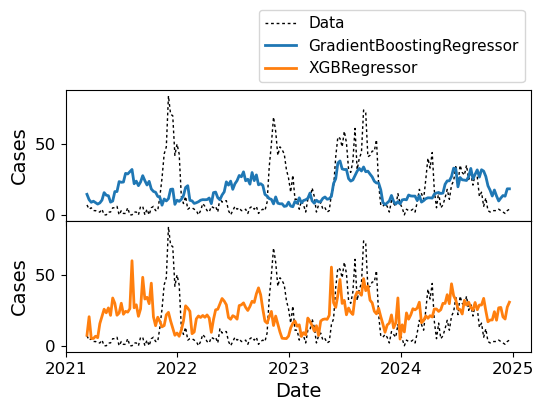

In [43]:
model_labels = ["GradientBoostingRegressor", "XGBRegressor"]
num_models_auto = len(model_labels)
dates_true = df_test["ds"]
chol_true = df_test["y"]
dates_range = (dates_true.max() - dates_true.min()).days
dates_ticks = pd.date_range(start=dates_true.min(), end=dates_true.max(), periods = 4)
fig, axes = plt.subplots(num_models_auto, 1, figsize=(6, 1.7 * num_models_auto), sharex=True)
axes[0].plot(
    dates_true,
    chol_true,
    color = "black",
    linewidth = 1,
    dashes = [2, 2],
    label = "Data"
)
axes[0].plot(
    dates_true,
    skgbr_preds_train,
    color = "C0",
    linewidth = 2,
    label = model_labels[0]
)
axes[0].tick_params(labelsize = 12)
axes[0].set_ylabel("Cases", fontsize = 14)
axes[0].set(xticks=dates_ticks)
axes[1].plot(
    dates_true,
    chol_true,
    color = "black",
    linewidth = 1,
    dashes = [2, 2],
    label = "Data"
)
axes[1].plot(
    dates_true,
    xgbr_preds_train,
    color = "C1",
    linewidth = 2,
    label = model_labels[1]
)
axes[1].tick_params(labelsize = 12)
axes[1].set_ylabel("Cases", fontsize = 14)
axes[1].set(xticks=dates_ticks)

axes[1].set(xticks=["2021-01-01", "2022-01-01", "2023-01-01", "2024-01-01", "2025-01-01"])
axes[1].set_xticklabels(["2021", "2022", "2023", "2024", "2025"], fontsize = 12) 
axes[1].set_xlabel("Date", fontsize = 14)
plt.minorticks_off()

lines_labels = [ax.get_legend_handles_labels() for ax in axes]
h, l = [sum(lol, []) for lol in zip(*lines_labels)]
h = [h[0]] + h[1::2]
l = [l[0]] + l[1::2]
axes[0].legend(
    h, 
    l, 
    bbox_to_anchor=(0.4, 1),
    fontsize = 11
)
axes[-1].set_xlabel("Date", fontsize = 14)
plt.subplots_adjust(hspace = 0)

### Feature Importance

In [44]:
df_xgbr_importances_train = (
    pd.DataFrame(
        data = np.c_[
            df_train.columns[3:].values,
            xgbr_final_train.feature_importances_
        ],
        columns = ["feature", "importance"]
    )
    .sort_values("importance", ascending = False)
    .reset_index(drop = True)
    # .iloc[:10]
    .loc[lambda x: x["importance"] >= 0.01]
)

df_skgbr_importances_train = (
    pd.DataFrame(
        data = np.c_[
            df_train.columns[3:].values,
            skgbr_final_train.feature_importances_
        ],
        columns = ["feature", "importance"]
    )
    .sort_values("importance", ascending = False)
    .reset_index(drop = True)
    # .iloc[:10]
    .loc[lambda x: x["importance"] >= 0.01]
)

In [45]:
df_xgbr_importances_train["importance"].sum()

0.7187655465677381

In [46]:
df_skgbr_importances_train["importance"].sum()

0.16009101592599975

In [47]:
df_xgbr_importances_train.shape

(22, 2)

In [48]:
df_skgbr_importances_train.shape

(8, 2)

In [49]:
df_xgbr_importances_train

,feature,importance
0,rainfall_mm__maximum,0.140474
1,esi__median,0.138586
2,esi__quantile__q_0.6,0.062893
3,rainfall_mm__minimum,0.034646
4,"esi__change_quantiles__f_agg_""mean""__isabs_Fal...",0.03394
5,esi__max_langevin_fixed_point__m_3__r_30,0.032013
6,"num_fatalities__change_quantiles__f_agg_""var""_...",0.029952
7,lake_level__autocorrelation__lag_3,0.028923
8,lake_level__cwt_coefficients__coeff_1__w_2__wi...,0.025979
9,lake_level__ratio_beyond_r_sigma__r_1,0.021344


#### Features correlation

<Axes: >

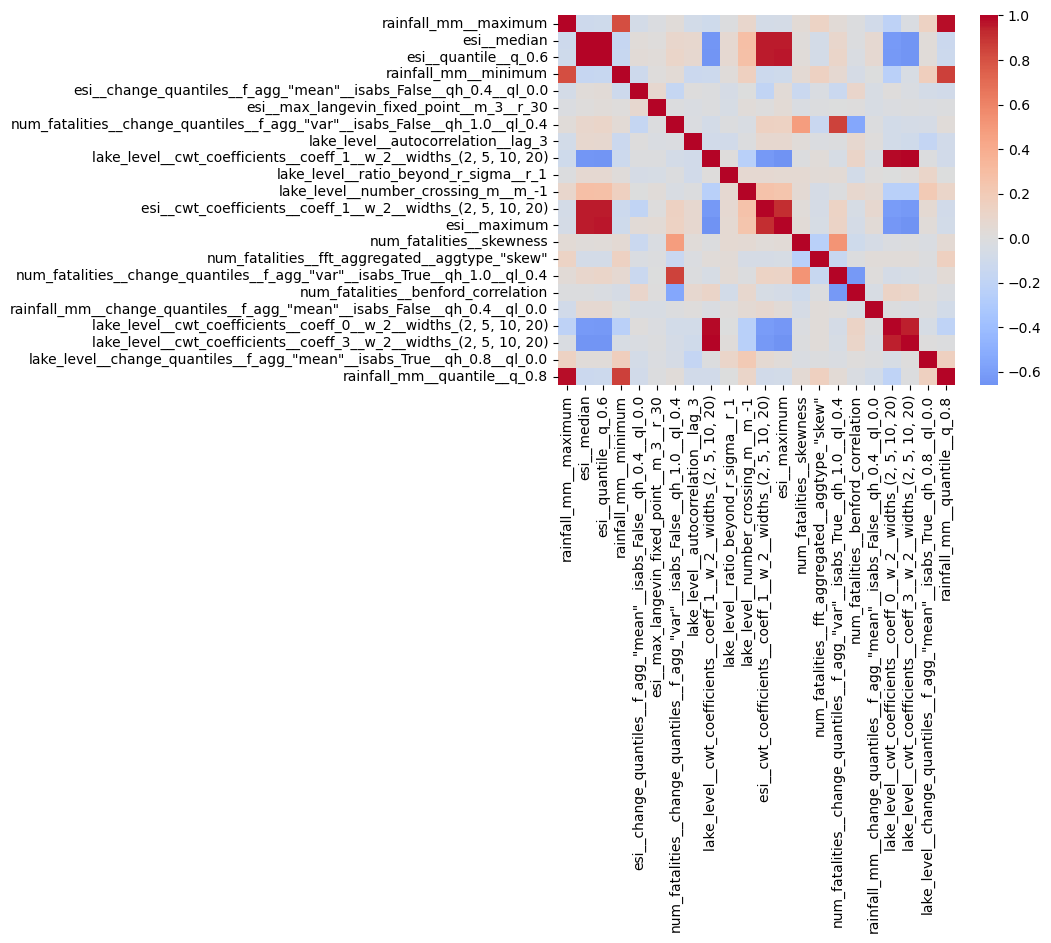

In [50]:
sns.heatmap(
    df_model
    [df_xgbr_importances_train["feature"].values.tolist()]
    .corr(),
    center = 0,
    cmap = "coolwarm",
)

<Axes: >

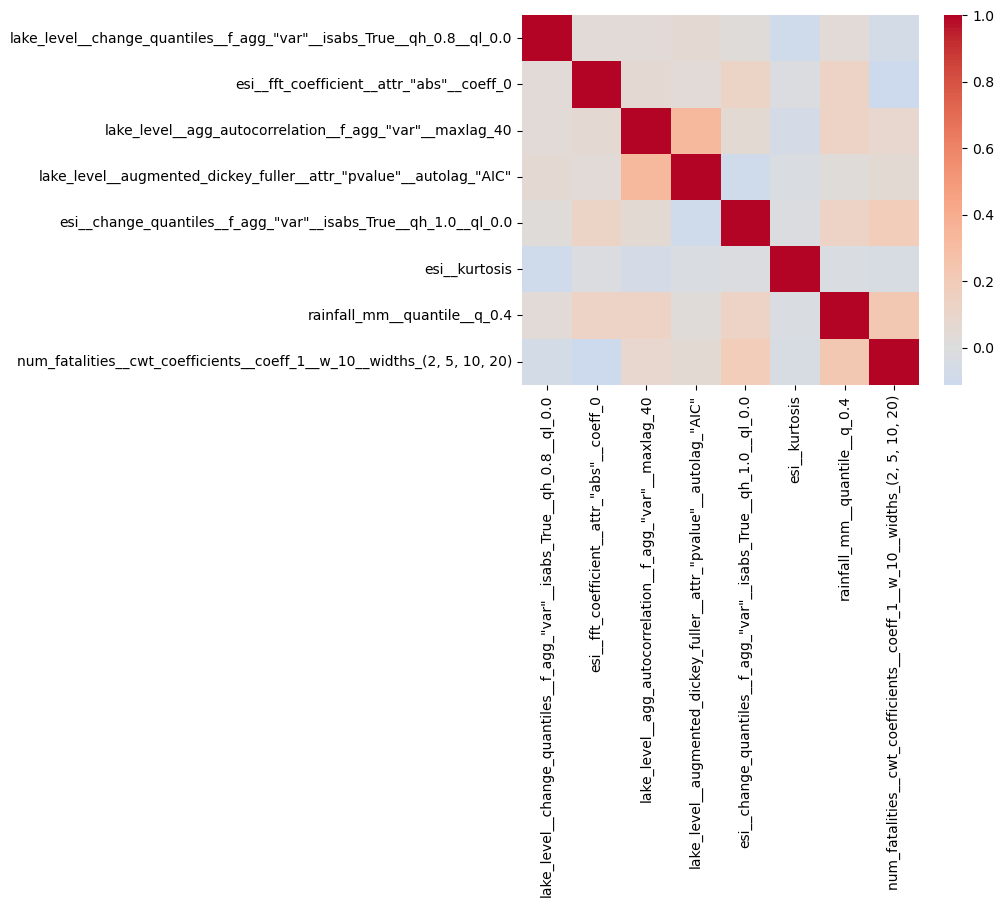

In [51]:
sns.heatmap(
    df_model
    [df_skgbr_importances_train["feature"].values.tolist()]
    .corr(),
    center = 0,
    cmap = "coolwarm",
)

#### Extract features with low correlation

In [52]:
model_to_use = df_skgbr_importances_train

In [53]:
list_of_relevant_features_xgbr_train = [df_xgbr_importances_train["feature"].values.tolist()[0]]
for f in df_xgbr_importances_train["feature"].values.tolist()[1:]:
    corrs = df_model[list_of_relevant_features_xgbr_train + [f]].corr()[f].abs()
    if corrs[:-1].max() < 0.55:
        list_of_relevant_features_xgbr_train.append(f)    


list_of_relevant_features_skgbr_train = [df_skgbr_importances_train["feature"].values.tolist()[0]]
for f in df_skgbr_importances_train["feature"].values.tolist()[1:]:
    corrs = df_model[list_of_relevant_features_skgbr_train + [f]].corr()[f].abs()
    if corrs[:-1].max() < 0.55:
        list_of_relevant_features_skgbr_train.append(f) 

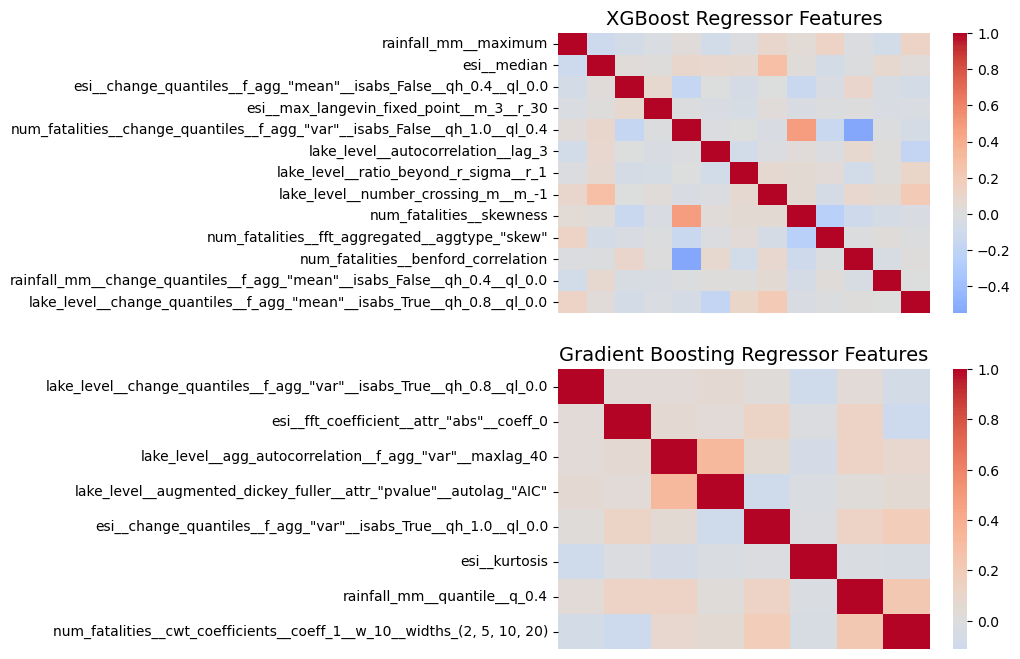

In [54]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))
sns.heatmap(
    df_model
    [list_of_relevant_features_xgbr_train]
    .corr(),
    ax = axes[0],
    cmap = "coolwarm",
    center = 0,
)
axes[0].set_title("XGBoost Regressor Features", fontsize = 14)
axes[0].set_xticks([])
sns.heatmap(
    df_model
    [list_of_relevant_features_skgbr_train]
    .corr(),
    ax = axes[1],
    cmap = "coolwarm",
    center = 0,
)
axes[1].set_title("Gradient Boosting Regressor Features", fontsize = 14)
axes[1].set_xticks([]);

### Use SHAP values to generate covariance

In [55]:
xgbr_explainer_train = shap.Explainer(xgbr_final_train)
skgbr_explainer_train = shap.Explainer(skgbr_final_train)

In [56]:
xgbr_shap_values_train = xgbr_explainer_train(df_model.drop(columns = ["ds", "y", "unique_id"]))
skgbr_shap_values_train = skgbr_explainer_train(df_model.drop(columns = ["ds", "y", "unique_id"]))

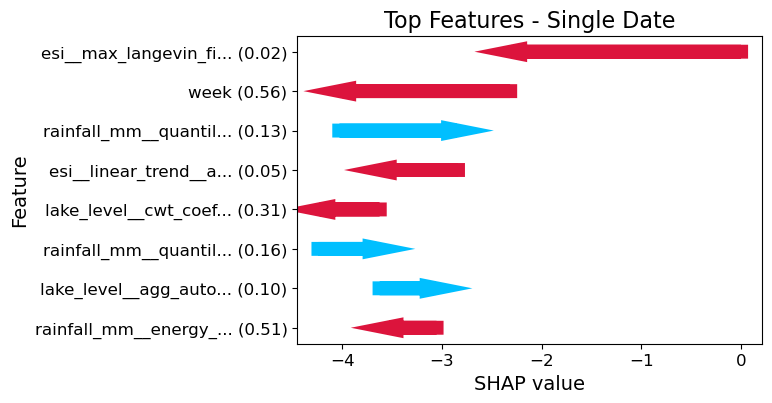

In [57]:
# Data point to plot
data_to_plot = skgbr_shap_values_train
p = 1

# Extract feature names, shap values, and data values
feature_names = data_to_plot[p].feature_names
shap_values = data_to_plot[p].values
data_values = data_to_plot[p].data

# Get the absolute values of the SHAP values and sort them
sorted_indices = np.argsort(np.abs(shap_values))[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]
sorted_shap_values = shap_values[sorted_indices]
sorted_data_values = data_values[sorted_indices]

# Select the top features
top_n = 8
top_feature_names = sorted_feature_names[:top_n][::-1]
top_feature_names = [n[:20] + "..." if len(n) > 20 else n for n in top_feature_names]
labels = [f"{name} ({value:.2f})" for name, value in zip(top_feature_names, sorted_data_values[:top_n][::-1])]
top_shap_values = sorted_shap_values[:top_n][::-1]

# Calculate the cumulative sum of the SHAP values
cumulative_shap_values = -(np.cumsum(top_shap_values) - np.cumsum(top_shap_values)[-1])

# Create the waterfall plot with arrows
fig, ax = plt.subplots(figsize=(6, 4))
colors = ["crimson" if val < 0 else "deepskyblue" for val in top_shap_values]
for i in range(top_n):
    ax.arrow(
        cumulative_shap_values[i], 
        i, 
        top_shap_values[i], 
        0,
        head_width=0.1, 
        head_length=0.1, 
        length_includes_head = True,
        fc=colors[i], 
        ec=colors[i],
        linewidth = 10
    )
ax.set_yticks(range(top_n))
ax.set_yticklabels(labels)
ax.set_xlabel("SHAP value", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title("Top Features - Single Date", fontsize=16)
plt.savefig(img_dir / "shap_waterfall.png", dpi = 300, bbox_inches = "tight")
plt.show()

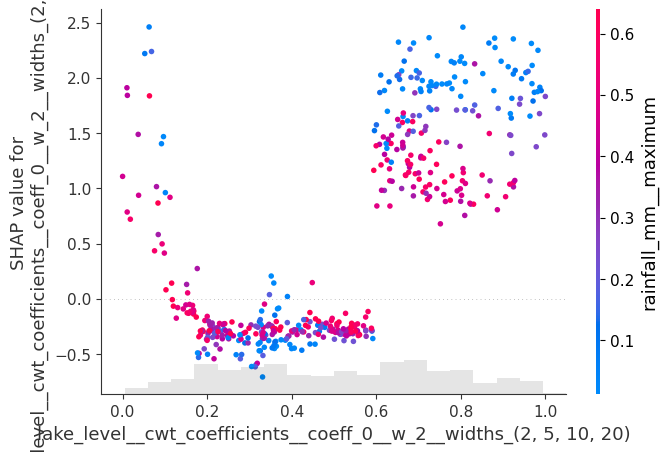

In [58]:
shap.plots.scatter(data_to_plot[:, "lake_level__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)"], color=data_to_plot)

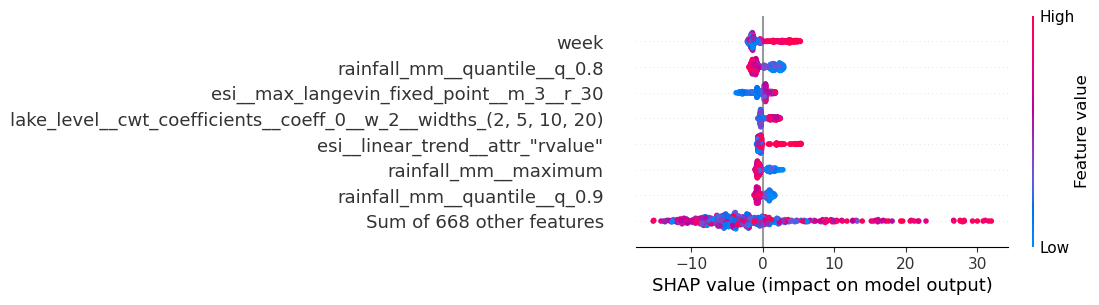

In [59]:
ax = shap.plots.beeswarm(
    data_to_plot,
    max_display=8,
    plot_size = (6, 3),
    show=False
)
# ax.set_yticks(ax.get_yticks()[::-1])
# ax.set_yticklabels([
#     "lake level coef 1", 
#     "esi coef 2", 
#     "lake level coef 2",
#      "rainfall coef", 
#      "lake level max", 
#      "lake level quantile", 
#      "lake level minimum",
#      "other features"
# ])
plt.savefig(img_dir / "shap_xgbr.png", dpi = 300, bbox_inches = "tight")

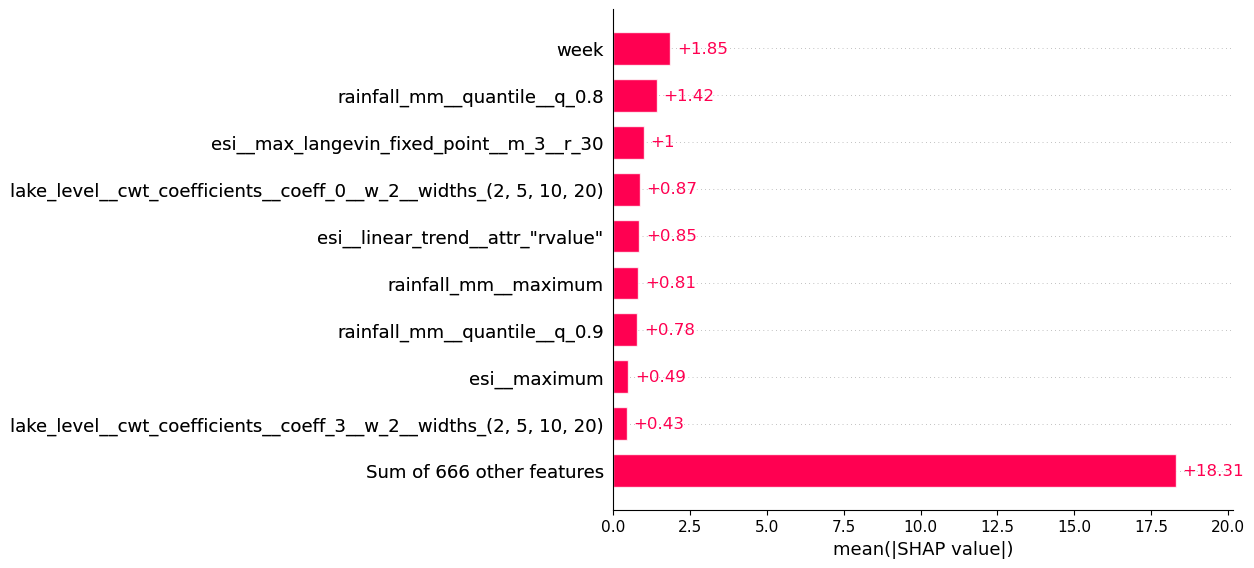

In [60]:
shap.plots.bar(data_to_plot)

In [61]:
df_xgbr_shap_importances_train = (
    pd.DataFrame(
        data = xgbr_shap_values_train.values,
        columns = xgbr_shap_values_train.feature_names,
    )
    .apply(lambda x: x.abs().mean())
    .sort_values(ascending = False)
    .to_frame(name = "importance")
    .assign(
        importance = lambda x: x["importance"] / x["importance"].sum()
    )
    .reset_index()
    .rename(columns = {"index": "feature"})
)

df_skgbr_shap_importances_train = (
    pd.DataFrame(
        data = skgbr_shap_values_train.values,
        columns = skgbr_shap_values_train.feature_names,
    )
    .apply(lambda x: x.abs().mean())
    .sort_values(ascending = False)
    .to_frame(name = "importance")
    .assign(
        importance = lambda x: x["importance"] / x["importance"].sum()
    )
    .reset_index()
    .rename(columns = {"index": "feature"})
)

In [62]:
df_xgbr_shap_importances_train.shape

(675, 2)

#### SHAP values for top covariates

We use the relevant features obtained from feature importance and low correlation.

In [63]:
df_xgbr_shap_train = (
    pd.DataFrame(
        data = xgbr_shap_values_train.values,
        columns = xgbr_shap_values_train.feature_names,
    )
    [list_of_relevant_features_xgbr_train]
)
df_skgbr_shap_train = (
    pd.DataFrame(
        data = skgbr_shap_values_train.values,
        columns = skgbr_shap_values_train.feature_names,
    )
    [list_of_relevant_features_skgbr_train]
)

In [64]:
df_xgbr_shap_train.head()

,rainfall_mm__maximum,esi__median,"esi__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0",esi__max_langevin_fixed_point__m_3__r_30,"num_fatalities__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4",lake_level__autocorrelation__lag_3,lake_level__ratio_beyond_r_sigma__r_1,lake_level__number_crossing_m__m_-1,num_fatalities__skewness,"num_fatalities__fft_aggregated__aggtype_""skew""",num_fatalities__benford_correlation,"rainfall_mm__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","lake_level__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0"
0,-4.914104,-0.358353,-0.414952,0.101245,-0.058911,0.518371,-0.019366,-0.244992,-0.208461,-0.288504,-0.029031,1.171011,-0.024244
1,-3.108208,-0.362518,-0.418532,-0.117948,-0.058910,0.324677,-0.021471,-0.238188,-0.210466,-0.031724,-0.025379,-0.275126,-0.037459
2,-4.236651,-0.341882,-0.411834,-0.898243,-0.056078,0.532296,-0.027652,-0.238895,-0.201798,-0.034196,-0.026995,1.398119,-0.021193
3,-0.645972,-0.249420,-0.251315,-0.781787,-0.054740,0.376699,0.088898,-0.148182,-0.004651,-0.031083,-0.139989,-0.213846,-0.018613
4,10.872707,-1.430178,-0.146306,1.392158,-0.032765,2.552092,-0.012947,-0.070498,-0.056622,-0.018977,-0.199341,-0.614369,-0.077825


Text(0.5, 1.0, 'XGBoost Regressor SHAP Values')

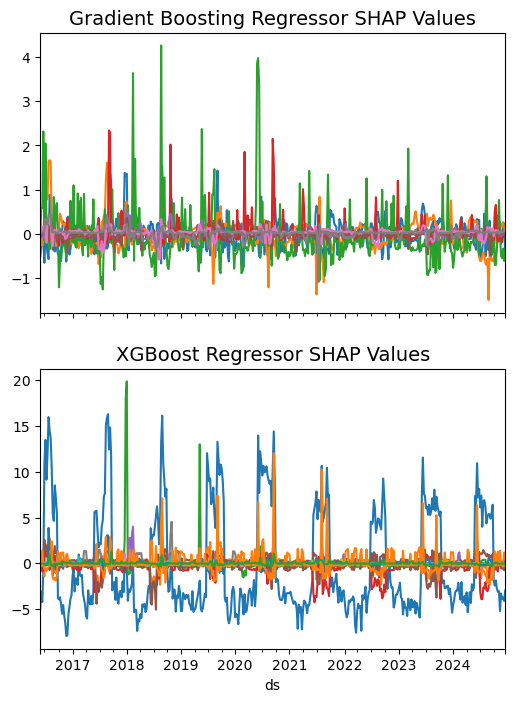

In [65]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
(
    pd.concat([df_model["ds"], df_skgbr_shap_train], axis = 1)
    .set_index("ds")
    .plot(legend=False, ax=axes[0])
)
axes[0].set_title("Gradient Boosting Regressor SHAP Values", fontsize = 14)
(
    pd.concat([df_model["ds"], df_xgbr_shap_train], axis = 1)
    .set_index("ds")
    .plot(legend=False, ax=axes[1])
)
axes[1].set_title("XGBoost Regressor SHAP Values", fontsize = 14)

#### Combine SHAP values

This requires a bit of thinking.
A negative SHAP value is associated to a reduction in the output regardless of the sign of the covariate so we cannot multiply the two without losing this information.

We first calculate the average SHAP values and multiply the respective features by this.

In [66]:
list_of_relevant_features_skgbr_train

['lake_level__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
 'esi__fft_coefficient__attr_"abs"__coeff_0',
 'lake_level__agg_autocorrelation__f_agg_"var"__maxlag_40',
 'lake_level__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"',
 'esi__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0',
 'esi__kurtosis',
 'rainfall_mm__quantile__q_0.4',
 'num_fatalities__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)']

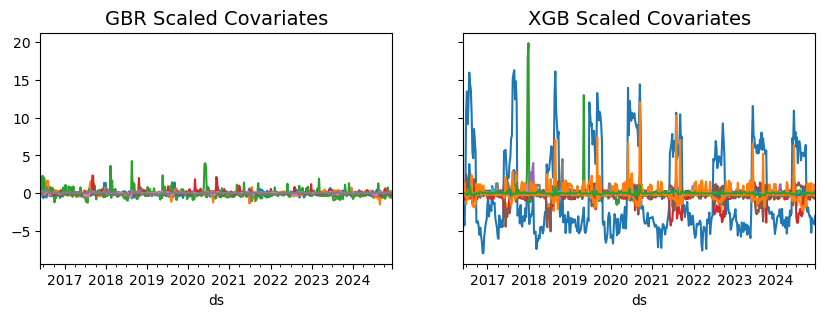

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
(
    df_model
    [["ds"] + list_of_relevant_features_skgbr_train]
    # .assign(
    #     **{
    #         f"{feat}_shap": np.sign(df_skgbr_shap_train[feat]) * df_model[feat] * df_skgbr_shap_importances_train.loc[lambda x: x["feature"] == feat]["importance"].values[0]
    #         for feat in list_of_relevant_features_skgbr_train
    #     }
    # )
    .assign(
        **{
            f"{feat}_shap": df_skgbr_shap_train[feat] for feat in list_of_relevant_features_skgbr_train
        }
    )
    .drop(columns = [c for c in list_of_relevant_features_skgbr_train])
    .set_index("ds")
    .plot(legend=False, ax=axes[0])
)
axes[0].set_title("GBR Scaled Covariates", fontsize = 14)
(
    df_model
    [["ds"] + list_of_relevant_features_xgbr_train]
    # .assign(
    #     **{
    #         f"{feat}_shap": np.sign(df_xgbr_shap_train[feat]) * df_model[feat] * df_xgbr_shap_importances_train.loc[lambda x: x["feature"] == feat]["importance"].values[0]
    #         for feat in list_of_relevant_features_xgbr_train
    #     }
    # )
    .assign(
        **{
            f"{feat}_shap": df_xgbr_shap_train[feat] for feat in list_of_relevant_features_xgbr_train
        }
    )
    .drop(columns = [c for c in list_of_relevant_features_xgbr_train])
    .set_index("ds")
    .plot(legend=False, ax=axes[1])
)
axes[1].set_title("XGB Scaled Covariates", fontsize = 14);


#### Final Dataset

In [68]:
df_reports_cov_skgbr_shap_train = (
    df_model
    [["ds", "y"] + list_of_relevant_features_skgbr_train]
    .assign(
        **{
            f"{feat}_shap": np.sign(df_skgbr_shap_train[feat]) * df_model[feat] * df_skgbr_shap_importances_train.loc[lambda x: x["feature"] == feat]["importance"].values[0]
            for feat in list_of_relevant_features_skgbr_train
        }
    )
    # .assign(
    #     **{
    #         f"{feat}_shap": df_skgbr_shap_train[feat] for feat in list_of_relevant_features_skgbr_train
    #     }
    # )
    .assign(
        cov = lambda x: normalize(
            x
            [[c for c in x.columns if c.endswith("_shap")]]
            .sum(axis = 1)
        )
    )
    .merge(
        df_weekly[["ds", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop"]],
        on = "ds",
        how = "left"
    )
    .rename(
        columns = {
            "ds": "date",
            "y": "reports"
        }
    )
    [["date", "reports", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop", "cov"] + list_of_relevant_features_skgbr_train]
)

df_reports_cov_xgbr_shap_train = (
    df_model
    [["ds", "y"] + list_of_relevant_features_xgbr_train]
    .assign(
        **{
            f"{feat}_shap": np.sign(df_xgbr_shap_train[feat]) * df_model[feat] * df_xgbr_shap_importances_train.loc[lambda x: x["feature"] == feat]["importance"].values[0]
            for feat in list_of_relevant_features_xgbr_train
        }
    )
    # .assign(
    #     **{
    #         f"{feat}_shap": df_xgbr_shap_train[feat] for feat in list_of_relevant_features_xgbr_train
    #     }
    # )
    .assign(
        cov = lambda x: normalize(
            x
            [[c for c in x.columns if c.endswith("_shap")]]
            .sum(axis = 1)
        )
    )
    .merge(
        df_weekly[["ds", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop"]],
        on = "ds",
        how = "left"
    )
    .rename(
        columns = {
            "ds": "date",
            "y": "reports"
        }
    )
    [["date", "reports", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop", "cov"] + list_of_relevant_features_xgbr_train]
)

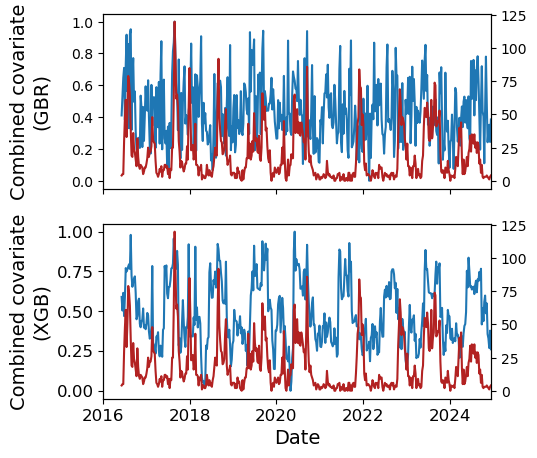

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
(
    df_reports_cov_skgbr_shap_train
    .set_index("date")
    .plot(
        y = "cov",
        ax = axes[0], 
        legend = False
    )
)
ax2 = axes[0].twinx()
(
    df_reports_cov_skgbr_shap_train
    .set_index("date")
    .plot(
        y = "reports",
        ax = ax2, 
        legend = False,
        color = "firebrick"
    )
)
axes[0].set_ylabel("Combined covariate\n(GBR)", fontsize = 14)
(
    df_reports_cov_xgbr_shap_train
    .set_index("date")
    .plot(
        y = "cov",
        ax = axes[1], 
        legend = False
    )
)
ax2 = axes[1].twinx()
(
    df_reports_cov_xgbr_shap_train
    .set_index("date")
    .plot(
        y = "reports",
        ax = ax2, 
        legend = False,
        color = "firebrick"
    )
)
axes[1].set_ylabel("Combined covariate\n(XGB)", fontsize = 14)
axes[1].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
axes[1].set_xticklabels(["2016", "2018", "2020", "2022", "2024"], fontsize = 12) 
axes[1].set_xlabel("Date", fontsize = 14)
axes[1].tick_params(axis = "y", labelsize = 12)
fig.align_ylabels(axes)
plt.minorticks_off()
plt.savefig(img_dir / "combined_covariates.png", dpi = 300, bbox_inches = "tight")

### Use correlation factors to build covariance

In [70]:
corr_factors_skgbr_train = (
    df_train
    [["y"] + list_of_relevant_features_skgbr_train]
    .corr()
    ["y"]
    .T
    .to_frame(name = "corr")
    .loc[lambda x: x.index != "y"]
    .sort_values(by = "corr", ascending = False, key = np.abs)
)

corr_factors_xgbr_train = (
    df_train
    [["y"] + list_of_relevant_features_xgbr_train]
    .corr()
    ["y"]
    .T
    .to_frame(name = "corr")
    .loc[lambda x: x.index != "y"]
    .sort_values(by = "corr", ascending = False, key = np.abs)
)

#### Final Dataset

In [71]:
df_reports_cov_corr_skgbr_train = (
    df_model
    [["ds", "y"] + list_of_relevant_features_skgbr_train]
    .assign(
        **{
            f"{feat}_corr": df_model[feat] * corr_factors_skgbr_train.loc[lambda x: x.index == feat, "corr"].values[0]
            for feat in list_of_relevant_features_skgbr_train
        }
    )
    .assign(
        cov = lambda x: normalize(
            x
            [[c for c in x.columns if c.endswith("_corr")]]
            .sum(axis = 1)
        )
    )
    .merge(
        df_weekly[["ds", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop"]],
        on = "ds",
        how = "left"
    )
    .rename(
        columns = {
            "ds": "date",
            "y": "reports"
        }
    )
    [["date", "reports", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop", "cov"] + list_of_relevant_features_skgbr_train]
)

df_reports_cov_corr_xgbr_train = (
    df_model
    [["ds", "y"] + list_of_relevant_features_xgbr_train]
    .assign(
        **{
            f"{feat}_corr": df_model[feat] * corr_factors_xgbr_train.loc[lambda x: x.index == feat, "corr"].values[0]
            for feat in list_of_relevant_features_xgbr_train
        }
    )
    .assign(
        cov = lambda x: normalize(
            x
            [[c for c in x.columns if c.endswith("_corr")]]
            .sum(axis = 1)
        )
    )
    .merge(
        df_weekly[["ds", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop"]],
        on = "ds",
        how = "left"
    )
    .rename(
        columns = {
            "ds": "date",
            "y": "reports"
        }
    )
    [["date", "reports", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop", "cov"] + list_of_relevant_features_xgbr_train]
)
    

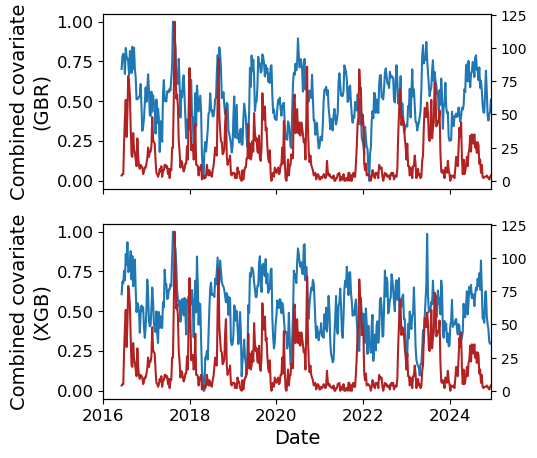

In [72]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
(
    df_reports_cov_corr_skgbr_train
    .set_index("date")
    .plot(
        y = "cov",
        ax = axes[0], 
        legend = False
    )
)
ax2 = axes[0].twinx()
(
    df_reports_cov_corr_skgbr_train
    .set_index("date")
    .plot(
        y = "reports",
        ax = ax2, 
        legend = False,
        color = "firebrick"
    )
)
axes[0].tick_params(axis = "y", labelsize = 12)
axes[0].set_ylabel("Combined covariate\n(GBR)", fontsize = 14)

(
    df_reports_cov_corr_xgbr_train
    .set_index("date")
    .plot(
        y = "cov",
        ax = axes[1], 
        legend = False
    )
)
ax2 = axes[1].twinx()
(
    df_reports_cov_corr_xgbr_train
    .set_index("date")
    .plot(
        y = "reports",
        ax = ax2, 
        legend = False,
        color = "firebrick"
    )
)
axes[1].tick_params(axis = "y", labelsize = 12)
axes[1].set_ylabel("Combined covariate\n(XGB)", fontsize = 14)

axes[1].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
axes[1].set_xticklabels(["2016", "2018", "2020", "2022", "2024"], fontsize = 12) 
axes[1].set_xlabel("Date", fontsize = 14)
fig.align_ylabels(axes)
plt.minorticks_off()
plt.savefig(img_dir / "combined_covariates.png", dpi = 300, bbox_inches = "tight")

## Model on all data

### Models

In [73]:
auto_xgbr_all = AutoModel(
    model=xgb.XGBRegressor(),
    config=xgbr_config,
)
auto_skgbr_all = AutoModel(
    model=GradientBoostingRegressor(),
    config=skgbr_config,
)

### Hyperparameter tuning

In [74]:
fcst_auto_all = AutoMLForecast(
    models = {
        "GradientBoostingRegressor": auto_skgbr_all,
        "XGBRegressor": auto_xgbr_all,
    },
    freq=f"{TIME_BIN}D",
    init_config = init_config_simple,
    fit_config=lambda trial: {'static_features': []}
)

In [75]:
fcst_auto_all.fit(
    df_model,
    n_windows=5,
    h=FORECAST_HORIZON,
    num_samples=3,
    fitted = True,
)

AutoMLForecast(models={'GradientBoostingRegressor': AutoModel(model=GradientBoostingRegressor), 'XGBRegressor': AutoModel(model=XGBRegressor)})

### Predictions on all data

In [76]:
df_forecast_auto_all = (
    fcst_auto_all
    .forecast_fitted_values()
    .drop(columns = ["unique_id"])
)

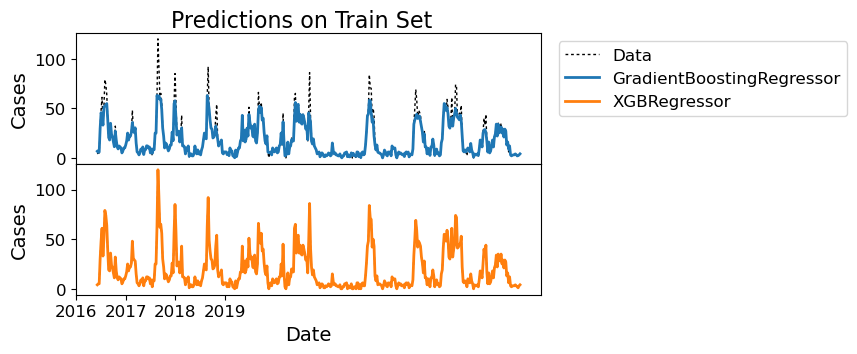

In [77]:
num_models_auto = len(fcst_auto_all.models)
fig, axes = plt.subplots(num_models_auto, 1, figsize=(6, 1.7 * num_models_auto), sharex=True)
for i in range(num_models_auto):
    axes[i].plot(
        df_model["ds"],
        df_model["y"],
        color = "black",
        linewidth = 1,
        dashes = [2, 2],
        label = "Data"
    )
    axes[i].plot(
        df_forecast_auto_all["ds"],
        df_forecast_auto_all.iloc[:, 2 + i],
        color = f"C{i}",
        linewidth = 2,
        label = df_forecast_auto_all.columns[2 + i]
    )
    axes[i].tick_params(labelsize = 12)
    axes[i].set_ylabel("Cases", fontsize = 14)
    axes[i].set(xticks=["2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"])
    axes[i].set_xticklabels(["2016", "2017", "2018", "2019"]);


lines_labels = [ax.get_legend_handles_labels() for ax in axes]
h, l = [sum(lol, []) for lol in zip(*lines_labels)]
h = [h[0]] + h[1::2]
l = [l[0]] + l[1::2]
axes[0].legend(
    h, 
    l, 
    bbox_to_anchor=(1.02, 1),
    fontsize = 12
)
axes[-1].set_xlabel("Date", fontsize = 14)
plt.suptitle("Predictions on Train Set", fontsize = 16, y = 0.95)
plt.subplots_adjust(hspace = 0)

### Refit best model

In [78]:
xgbr_final_all = xgb.XGBRegressor(**fcst_auto_all.results_["XGBRegressor"].best_params)

In [79]:
xgbr_final_all.fit(
    df_model.drop(columns = ["ds", "y", "unique_id"]),
    df_model["y"]
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.054789743550245906,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=515, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importance

In [80]:
df_xgbr_importances_all = (
    pd.DataFrame(
        data = np.c_[
            df_model.columns[3:].values,
            xgbr_final_all.feature_importances_
        ],
        columns = ["feature", "importance"]
    )
    .sort_values("importance", ascending = False)
    .reset_index(drop = True)
    # .iloc[:10]
    .loc[lambda x: x["importance"] >= 0.01]
)

In [81]:
df_xgbr_importances_all["importance"].sum()

0.6769377570599318

In [82]:
df_xgbr_importances_all.shape

(13, 2)

In [83]:
df_xgbr_importances_all

,feature,importance
0,esi__range_count__max_1__min_-1,0.334646
1,esi__quantile__q_0.4,0.105237
2,rainfall_mm__minimum,0.048937
3,esi__maximum,0.031009
4,"lake_level__linear_trend__attr_""intercept""",0.030929
5,"esi__linear_trend__attr_""intercept""",0.026548
6,esi__quantile__q_0.6,0.021487
7,lake_level__cwt_coefficients__coeff_3__w_2__wi...,0.016111
8,lake_level__cwt_coefficients__coeff_1__w_2__wi...,0.015894
9,lake_level__maximum,0.01433


#### Features correlation

<Axes: >

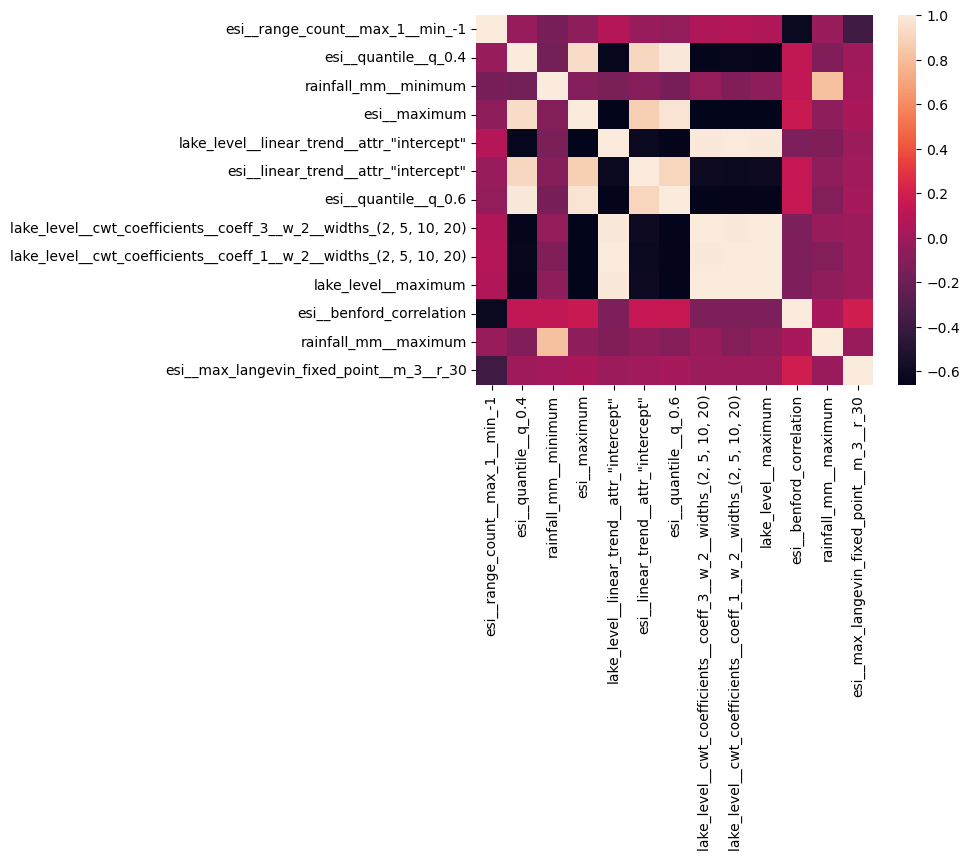

In [84]:
sns.heatmap(
    df_model
    [df_xgbr_importances_all["feature"].values.tolist()]
    .corr()
)

#### Extract features with low correlation

In [85]:
list_of_relevant_features_all = [df_xgbr_importances_all["feature"].values.tolist()[0]]
for f in df_xgbr_importances_all["feature"].values.tolist()[1:]:
    corrs = df_model[list_of_relevant_features_all + [f]].corr()[f].abs()
    if corrs[:-1].max() < 0.65:
        list_of_relevant_features_all.append(f)    

In [86]:
list_of_relevant_features_all

['esi__range_count__max_1__min_-1',
 'esi__quantile__q_0.4',
 'rainfall_mm__minimum',
 'lake_level__linear_trend__attr_"intercept"',
 'esi__benford_correlation',
 'esi__max_langevin_fixed_point__m_3__r_30']

<Axes: >

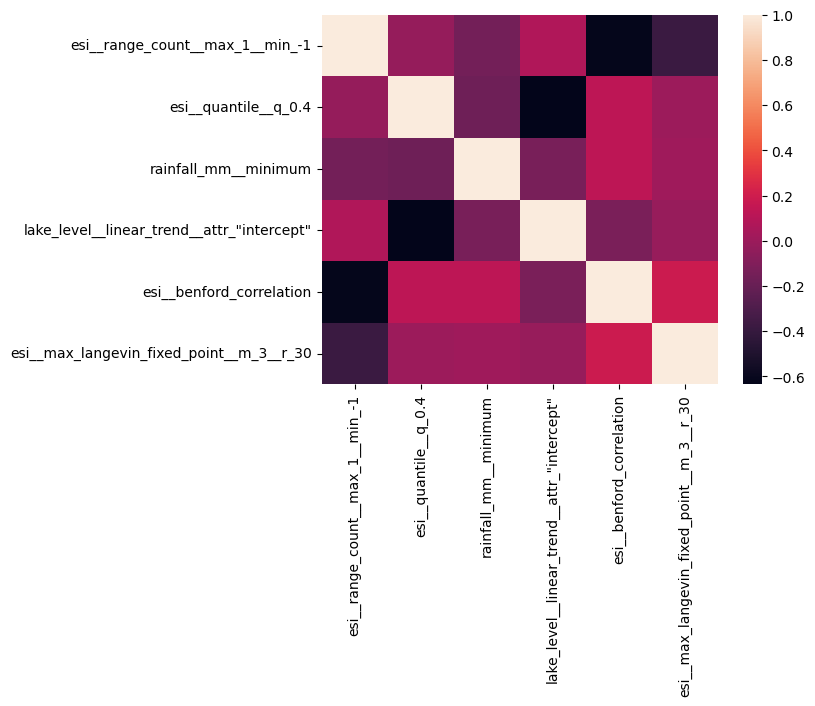

In [87]:
sns.heatmap(
    df_model
    [list_of_relevant_features_all]
    .corr()
)

### Use SHAP values to generate covariance

In [88]:
xgbr_explainer_all = shap.Explainer(xgbr_final_all)

In [89]:
xgbr_shap_values_all = xgbr_explainer_all(df_model.drop(columns = ["ds", "y", "unique_id"]))

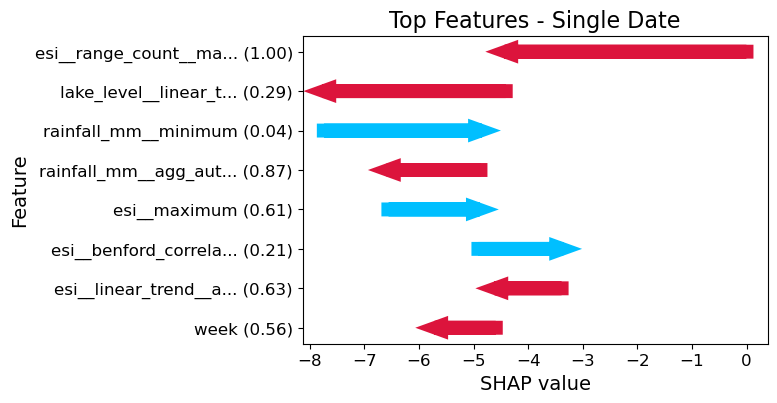

In [90]:
# Data point to plot
p = 1

# Extract feature names, shap values, and data values
feature_names = xgbr_shap_values_all[p].feature_names
shap_values = xgbr_shap_values_all[p].values
data_values = xgbr_shap_values_all[p].data

# Get the absolute values of the SHAP values and sort them
sorted_indices = np.argsort(np.abs(shap_values))[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]
sorted_shap_values = shap_values[sorted_indices]
sorted_data_values = data_values[sorted_indices]

# Select the top features
top_n = 8
top_feature_names = sorted_feature_names[:top_n][::-1]
top_feature_names = [n[:20] + "..." if len(n) > 20 else n for n in top_feature_names]
labels = [f"{name} ({value:.2f})" for name, value in zip(top_feature_names, sorted_data_values[:top_n][::-1])]
top_shap_values = sorted_shap_values[:top_n][::-1]

# Calculate the cumulative sum of the SHAP values
cumulative_shap_values = -(np.cumsum(top_shap_values) - np.cumsum(top_shap_values)[-1])

# Create the waterfall plot with arrows
fig, ax = plt.subplots(figsize=(6, 4))
colors = ["crimson" if val < 0 else "deepskyblue" for val in top_shap_values]
for i in range(top_n):
    ax.arrow(
        cumulative_shap_values[i], 
        i, 
        top_shap_values[i], 
        0,
        head_width=0.1, 
        head_length=0.1, 
        length_includes_head = True,
        fc=colors[i], 
        ec=colors[i],
        linewidth = 10
    )
ax.set_yticks(range(top_n))
ax.set_yticklabels(labels)
ax.set_xlabel("SHAP value", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title("Top Features - Single Date", fontsize=16)
plt.savefig(img_dir / "shap_waterfall.png", dpi = 300, bbox_inches = "tight")
plt.show()

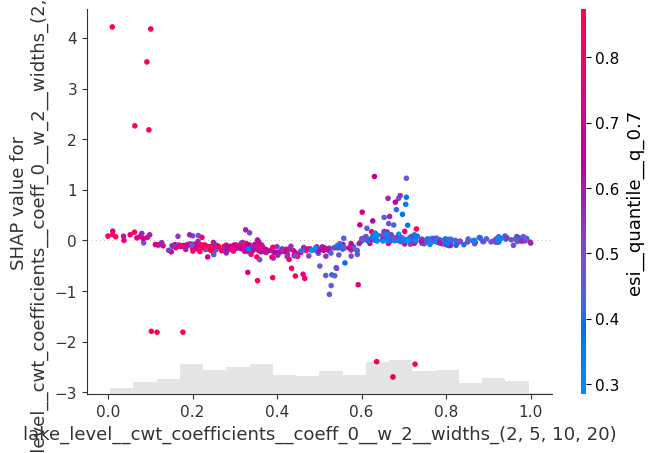

In [91]:
shap.plots.scatter(xgbr_shap_values_all[:, "lake_level__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)"], color=xgbr_shap_values_all)

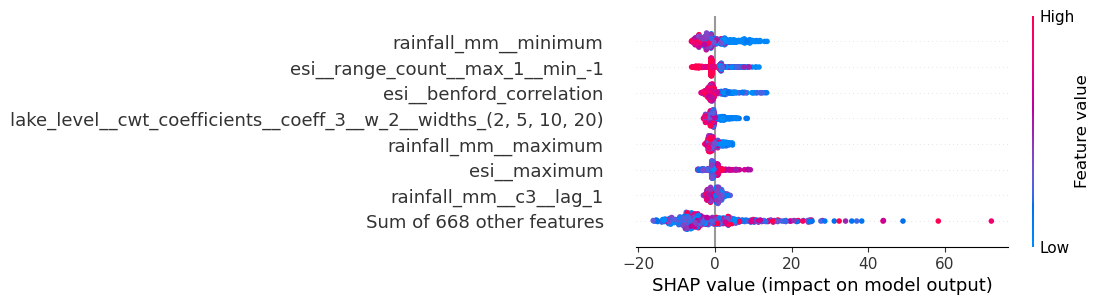

In [92]:
ax = shap.plots.beeswarm(
    xgbr_shap_values_all,
    max_display=8,
    plot_size = (6, 3),
    show=False
)
# ax.set_yticks(ax.get_yticks()[::-1])
# ax.set_yticklabels([
#     "lake level coef 1", 
#     "esi coef 2", 
#     "lake level coef 2",
#      "rainfall coef", 
#      "lake level max", 
#      "lake level quantile", 
#      "lake level minimum",
#      "other features"
# ])
plt.savefig(img_dir / "shap_xgbr.png", dpi = 300, bbox_inches = "tight")

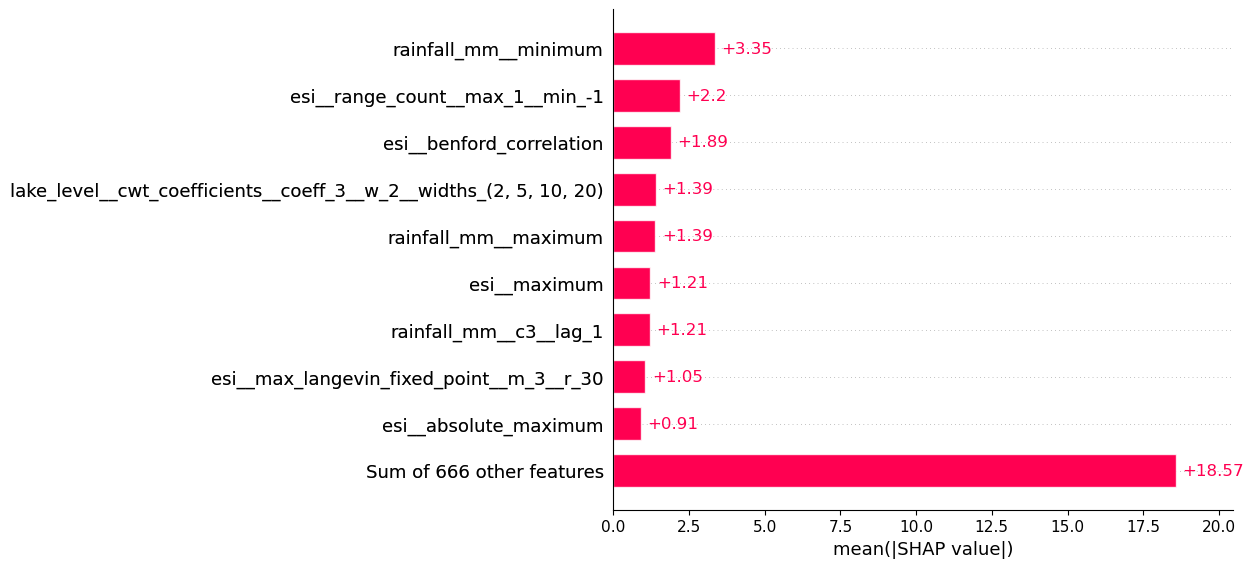

In [93]:
shap.plots.bar(xgbr_shap_values_all)

In [94]:
df_xgbr_shap_importances_all = (
    pd.DataFrame(
        data = xgbr_shap_values_all.values,
        columns = xgbr_shap_values_all.feature_names,
    )
    .apply(lambda x: x.abs().mean())
    .sort_values(ascending = False)
    .to_frame(name = "importance")
    .assign(
        importance = lambda x: x["importance"] / x["importance"].sum()
    )
    .reset_index()
    .rename(columns = {"index": "feature"})
)

In [96]:
df_xgbr_shap_importances_all.shape

(675, 2)

#### SHAP values for top covariates

We use the model feature importance rather than shap absolute values for selection.

In [97]:
df_xgbr_shap_all = (
    pd.DataFrame(
        data = xgbr_shap_values_all.values,
        columns = xgbr_shap_values_all.feature_names,
    )
    [list_of_relevant_features_all]
)

<Axes: xlabel='ds'>

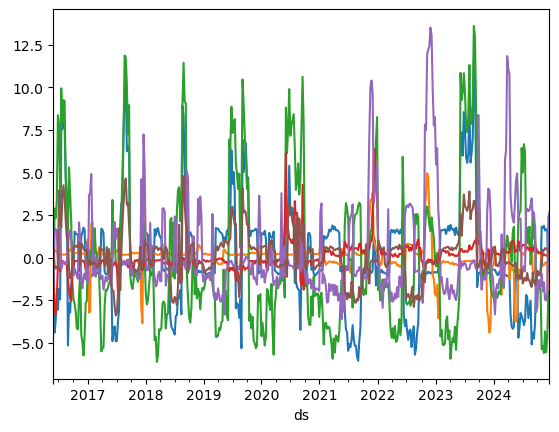

In [98]:
(
    pd.concat([df_model["ds"], df_xgbr_shap_all], axis = 1)
    .set_index("ds")
    .plot(legend=False)
)

#### Combine SHAP values

This requires a bit of thinking.
A negative SHAP value is associated to a reduction in the output regardless of the sign of the covariate so we cannot multiply the two without losing this information.

<Axes: xlabel='ds'>

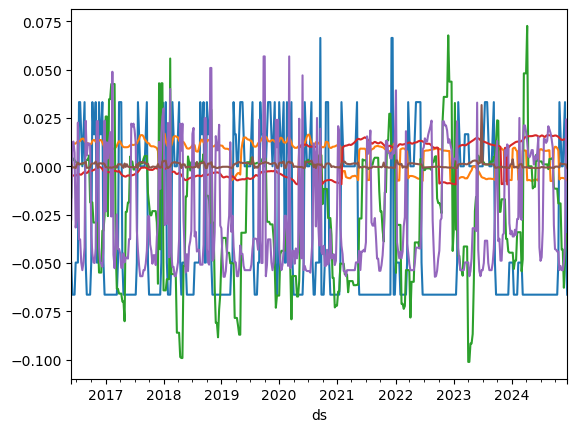

In [99]:
(
    df_model
    [["ds"] + list_of_relevant_features_all]
    .assign(
        **{
            f"{feat}_shap": np.sign(df_xgbr_shap_all[feat]) * df_model[feat] * df_xgbr_shap_importances_all.loc[lambda x: x["feature"] == feat]["importance"].values[0]
            for feat in list_of_relevant_features_all
        }
    )
    .drop(columns = [c for c in list_of_relevant_features_all])
    .set_index("ds")
    .plot(legend=False)
)

#### Final Dataset

In [100]:
df_reports_cov_shap_all = (
    df_model
    [["ds", "y"] + list_of_relevant_features_all]
    .assign(
        **{
            f"{feat}_shap": np.sign(df_xgbr_shap_all[feat]) * df_model[feat] * df_xgbr_shap_importances_all.loc[lambda x: x["feature"] == feat]["importance"].values[0]
            for feat in list_of_relevant_features_all
        }
    )
    .assign(
        cov = lambda x: normalize(
            x
            [[c for c in x.columns if c.endswith("_shap")]]
            .sum(axis = 1)
        )
    )
    .merge(
        df_weekly[["ds", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop"]],
        on = "ds",
        how = "left"
    )
    .rename(
        columns = {
            "ds": "date",
            "y": "reports"
        }
    )
    [["date", "reports", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop", "cov"] + list_of_relevant_features_all]
)

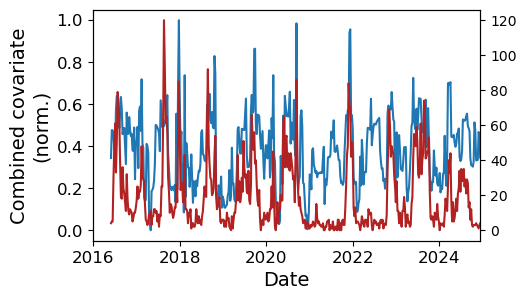

In [101]:
fig, ax = plt.subplots(figsize=(5, 3))
(
    df_reports_cov_shap_all
    .set_index("date")
    .plot(
        y = "cov",
        ax = ax, 
        legend = False
    )
)
ax2 = ax.twinx()
(
    df_reports_cov_shap_all
    .set_index("date")
    .plot(
        y = "reports",
        ax = ax2, 
        legend = False,
        color = "firebrick"
    )
)
ax.set_ylabel("Combined covariate\n(norm.)", fontsize = 14)
ax.set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
ax.set_xticklabels(["2016", "2018", "2020", "2022", "2024"], fontsize = 12) 
ax.set_xlabel("Date", fontsize = 14)
ax.tick_params(axis = "y", labelsize = 12)
fig.align_ylabels(axes)
plt.minorticks_off()
plt.savefig(img_dir / "combined_covariates.png", dpi = 300, bbox_inches = "tight")

### Use correlation factors to build covariance

In [102]:
corr_factors_all = (
    df_model
    [["y"] + list_of_relevant_features_all]
    .corr()
    ["y"]
    .T
    .to_frame(name = "corr")
    .loc[lambda x: x.index != "y"]
    .sort_values(by = "corr", ascending = False, key = np.abs)
)

#### Final Dataset

In [103]:
df_reports_cov_corr_all = (
    df_model
    [["ds", "y"] + list_of_relevant_features_all]
    .assign(
        **{
            f"{feat}_corr": df_model[feat] * corr_factors_all.loc[lambda x: x.index == feat, "corr"].values[0]
            for feat in list_of_relevant_features_all
        }
    )
    .assign(
        cov = lambda x: normalize(
            x
            [[c for c in x.columns if c.endswith("_corr")]]
            .sum(axis = 1)
        )
    )
    .merge(
        df_weekly[["ds", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop"]],
        on = "ds",
        how = "left"
    )
    .rename(
        columns = {
            "ds": "date",
            "y": "reports"
        }
    )
    [["date", "reports", "rdt_confirmed", "idps", "num_disaster_affected", "vacc_1", "vacc_1_prop", "vacc_2", "vacc_2_prop", "cov"] + list_of_relevant_features_all]
)
    

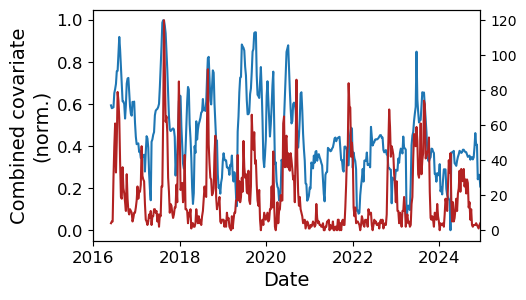

In [104]:
fig, ax = plt.subplots(figsize=(5, 3))
(
    df_reports_cov_corr_all
    .set_index("date")
    .plot(
        y = "cov",
        ax = ax, 
        legend = False
    )
)
ax2 = ax.twinx()
(
    df_reports_cov_corr_all
    .set_index("date")
    .plot(
        y = "reports",
        ax = ax2, 
        legend = False,
        color = "firebrick"
    )
)
ax.set_ylabel("Combined covariate\n(norm.)", fontsize = 14)
ax.set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
ax.set_xticklabels(["2016", "2018", "2020", "2022", "2024"], fontsize = 12) 
ax.set_xlabel("Date", fontsize = 14)
ax.tick_params(axis = "y", labelsize = 12)
fig.align_ylabels(axes)
plt.minorticks_off()
plt.savefig(img_dir / "combined_covariates.png", dpi = 300, bbox_inches = "tight")

## Output Data

In [105]:
df_reports_cov = df_reports_cov_corr_xgbr_train.copy()

In [106]:
df_reports_cov.head()

,date,reports,rdt_confirmed,idps,num_disaster_affected,vacc_1,vacc_1_prop,vacc_2,vacc_2_prop,cov,...,esi__max_langevin_fixed_point__m_3__r_30,"num_fatalities__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4",lake_level__autocorrelation__lag_3,lake_level__ratio_beyond_r_sigma__r_1,lake_level__number_crossing_m__m_-1,num_fatalities__skewness,"num_fatalities__fft_aggregated__aggtype_""skew""",num_fatalities__benford_correlation,"rainfall_mm__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","lake_level__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0"
0,2016-06-03,4,0,NaN,0.0,0.0,0.0,0.0,0.0,0.606563,...,0.044626,0.0,0.339466,1.0,0.0,0.5,1.006865e-15,0.719472,0.575043,0.276634
1,2016-06-10,5,0,NaN,0.0,0.0,0.0,0.0,0.0,0.686113,...,0.022031,0.0,0.731215,1.0,0.0,0.5,1.006865e-15,0.719472,0.588615,0.034606
2,2016-06-17,5,0,NaN,0.0,0.0,0.0,0.0,0.0,0.674560,...,0.017936,0.0,0.638755,1.0,0.0,0.5,1.006865e-15,0.719472,0.578798,0.042893
3,2016-06-24,30,12,NaN,0.0,0.0,0.0,0.0,0.0,0.754175,...,0.018309,0.0,0.308881,0.0,0.0,0.5,1.006865e-15,0.719472,0.596390,0.034606
4,2016-07-01,48,18,NaN,0.0,0.0,0.0,0.0,0.0,0.694788,...,0.028180,0.0,0.277471,1.0,0.0,0.5,1.006865e-15,0.719472,0.588615,0.221150


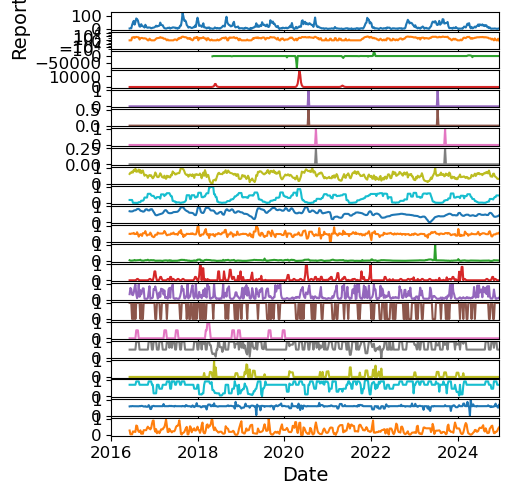

In [107]:
axes = df_reports_cov.set_index("date").plot(subplots = True, legend = False, figsize = (5, 5.5))
axes[0].set_ylabel("Reports", fontsize = 14)
axes[1].set_yscale("symlog")
axes[1].set(yticks=[-10000, -100, 0, 100, 10000])
axes[1].set_ylim(-150000, 150000)
axes[-1].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
axes[-1].set_xticklabels(["2016", "2018", "2020", "2022", "2024"], fontsize = 12) 
axes[-1].set_xlabel("Date", fontsize = 14)
for ax in axes:
    ax.tick_params(axis = "y", labelsize = 12)
plt.minorticks_off()
plt.subplots_adjust(hspace = 0.1)
fig = axes[0].get_figure()
fig.align_ylabels(axes)
plt.savefig(img_dir / "model_data.png", dpi = 300, bbox_inches = "tight")

In [109]:
OUTPUT_FILEDATE = pd.Timestamp("today").strftime("%Y%m%d")
df_reports_cov.to_csv(processed_data_dir / f"uvira_chol_cov_week_{OUTPUT_FILEDATE}.csv", index=False)

In [282]:
sd = 1.5
dates_0 = pd.date_range(start = "2023-01-01", end = "2024-01-01", freq = "1W")
dates_1 = pd.date_range(start = "2024-01-01", end = "2025-01-01", freq = "1W")
cases_pre_ch = 20 - 0.1 * np.arange(len(dates_0)) + rng.normal(0, sd, len(dates_0))
cases_ch = np.r_[cases_ch_1, cases_ch_2, cases_ch_3, cases_ch_4]
cases_ch_1 = 15 - 0.2 * np.arange(24) + rng.normal(0, sd, 24)
cases_ch_2 = cases_ch_1[-1] + 0.1 * np.arange(7) + rng.normal(0, sd, 7)
cases_ch_3 = cases_ch_2[-1] + 0.3 * np.arange(12) + rng.normal(0, sd, 12)
cases_ch_4 = cases_ch_2[-1] + 0.1 * np.arange(len(dates) - 24 - 7 - 12) + rng.normal(0, sd, len(dates) - 24 - 7 - 12)
cases_ch = np.r_[cases_ch_1, cases_ch_2, cases_ch_3, cases_ch_4]
cases_nch_1 = 12 - 0.2 * np.arange(24) + rng.normal(0, sd, 24)
cases_nch_2 = cases_nch_1[-1] + 0.3 * np.arange(7) + rng.normal(0, sd, 7)
cases_nch_3 = cases_nch_2[-1] + 0.1 * np.arange(len(dates) - 24 - 7) + rng.normal(0, sd, len(dates) - 24 - 7)
cases_nch = np.r_[cases_nch_1, cases_nch_2, cases_nch_3]

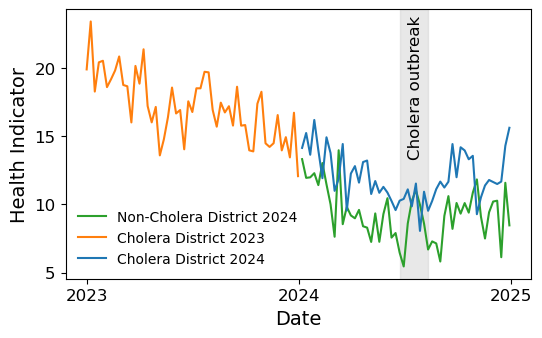

In [296]:
fig, ax = plt.subplots(figsize = (6, 3.5), sharex = True, sharey = True)
ax.axvspan(
    dates_1[24], 
    dates[24 + 7], 
    color = 
    "lightgrey", 
    alpha = 0.5,
)
ax.plot(
    dates, 
    cases_nch,
    label = "Non-Cholera District 2024",
    # color = "none",
    color = "C2"
)
ax.plot(
    dates_0, 
    cases_pre_ch,
    label = "Cholera District 2023",
    # color = "none"
    color = "C1"
)
ax.plot(
    dates_1, 
    cases_ch,
    label = "Cholera District 2024",
    color = "C0"
)
ax.legend(loc="lower left", frameon=False)
ax.text(0.737, 0.98, "Cholera outbreak", color = "black", transform=ax.transAxes, fontsize=12, rotation=90, verticalalignment='top')
ax.set_ylabel("Health Indicator", fontsize = 14)
ax.set(
    xticks=["2023-01-01", "2024-01-01", "2025-01-01"],
    yticks=[5, 10, 15, 20]
)
ax.set_xticklabels(["2023", "2024", "2025"], fontsize = 12) 
ax.set_xlabel("Date", fontsize = 14)
ax.tick_params(axis = "y", labelsize = 12)
plt.minorticks_off()
plt.savefig(img_dir / "all_districts.png", dpi = 300, bbox_inches = "tight")